### Advanced Time Series

이번 시간에서는 Financial Analysis의 최신 방법론과 이슈들에 대해 살펴보기로 한다

#### 1. Fractionally Differentiated Series

대부분의 금융 시계열 분석은 두가지 상황에서 딜레마에 빠진다
1. Box-Jenkins : log difference 데이터는 정상성을 가지지만, market memory를 가지지 않는다
2. Engle-Granger : log price 계열은 market memory를 가진다. 하지만 비정상성을 얻게 된다. Cointegration은 비정상성 시계열에서 회귀모형을 작동 가능하게 하지만 매우 제한적인 상황에서 발견되며, Cointegration의 안정성도 신뢰가 좋다고는 볼 수 없다

Fractional Difference는 ADF 검정 결과를 지키는 최소한의 차분계수($d$)통해 market memory와 stationarity를 모두 포함하는 변환을 해주는 통계학 방법이다

**1.1 Methodology**

실수값인 feature $\{X_t\}$에 적용한 backshift 연산자 $B$를 가정해 보자. 여기서 $k \geq 0$인 모든 정수에 대해 $B^kX_t = X_{t-k}$이다. 양의 정수 $n$에 $(x+y)^n = \sum_{k=0}^n {n \choose k} x^k y^{n-k} = \sum_{k=0}^n {n \choose k}x^{n-k}k^k$라는 것에 주목하자. 실수 $d$에서 $(1+x)^d = \sum_{k=0}^\infty {d \choose k} x^k$ 즉, 이항 계열이다. Fractionally differentiated model에서 지수 $d$는 실수값이 가능하고, 다음 형식의 이항 계열 확장을 따른다

$$\begin{matrix}
(1-B)^d = \sum_{k=0}^\infty {d \choose k}(-B)^k &=& \sum_{k=0}^\infty \frac{\prod_{i=0}^{k-1}(d-i)}{k!} \\
       &=& \sum_{k=0}^\infty (-B)^k \prod_{i=0}^{k-1}\frac{d-i}{k-i} \\
       &=& 1 - dB + \frac{d(d-1)}{2!}B^2 - \frac{d(d-1)(d-2)}{3!}B^3 + \cdots
\end{matrix}$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

start_date = '2015-01-01'
end_date = '2023-08-01'

apple = yf.download('AAPL', start = start_date, end = end_date).iloc[:,[0,1,2,3,5]]
apple

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000
...,...,...,...,...,...
2023-07-25,193.330002,194.440002,192.919998,193.619995,37283200
2023-07-26,193.669998,195.639999,193.320007,194.500000,47471900
2023-07-27,196.020004,197.199997,192.550003,193.220001,47460200


In [3]:
def getWeights(d, size):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[:: -1]).reshape(-1, 1)
    return w

def getWeights_FFD(d, thres):
    w = [1.]
    k = 1
    while abs(w[-1]) >= thres:
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        k += 1
    w = np.array(w[:: -1]).reshape(-1, 1)[1:]
    return w

def fracDiff_FFD(series, d, thres = 1e-5):
    w = getWeights_FFD(d, thres)
    # w = getWeights(d, series.shape[0])
    # w=getWeights_FFD(d,thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method = 'ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - width]
            loc1 = seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue 
            df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0: loc1])[0, 0]

        df[name] = df_.copy(deep = True)
    df = pd.concat(df, axis = 1)
    return df

def fracDiff(series, d, thres = .01):
    w = getWeights(d, series.shape[0]) 
    w_ = np.cumsum(abs(w)) 
    w_ /= w_[-1]  
    skip = w_[w_ > thres].shape[0]
    df = {} 
    for name in series.columns:
        seriesF = series[[name]].fillna(method = 'ffill').dropna()
        df_ = pd.Series() 
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]

            test_val = series.loc[loc, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue 
            try: 
                df_.loc[loc] = np.dot(w[-(iloc + 1):, :].T, seriesF.loc[:loc])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [4]:
cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(apple).dropna()
        df2 = fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/numpy/lib/fu

d: 0.1, error: division by zero
d: 0.2, error: Invalid input, x is constant
d: 0.30000000000000004, error: Invalid input, x is constant
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.075185,9.518548e-01,1.0,2155.0,-2.862882,1.000000
0.5,-1.260632,6.469853e-01,1.0,5.0,-3.929280,0.887011
0.6,-2.154825,2.230478e-01,1.0,13.0,-3.127149,0.556117
0.7,-3.912521,1.944609e-03,1.0,37.0,-2.943539,0.181059
0.8,-8.264837,4.970473e-13,1.0,107.0,-2.888955,0.146515
0.9,-13.747610,1.065264e-25,1.0,377.0,-2.869237,0.187848
1.0,-34.497045,0.000000e+00,1.0,2154.0,-2.862883,0.023718
1.1,-26.727279,0.000000e+00,1.0,1052.0,-2.864291,-0.003630
1.2,-29.551898,0.000000e+00,1.0,1114.0,-2.864138,0.002519
1.3,-34.233119,0.000000e+00,1.0,1318.0,-2.863735,0.006049


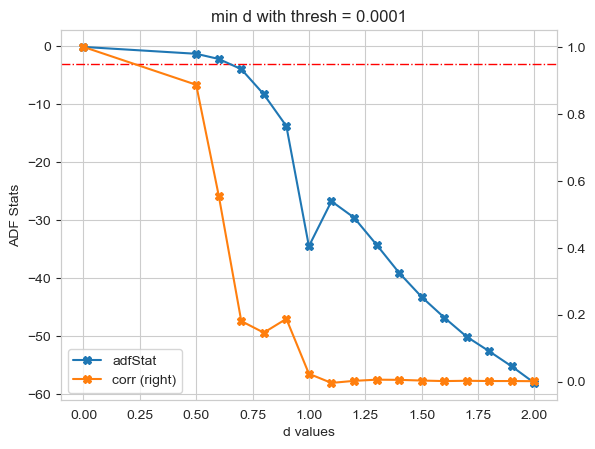

In [4]:
f,ax = plt.subplots()
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats');
display(out)

<Axes: xlabel='Close', ylabel='Count'>

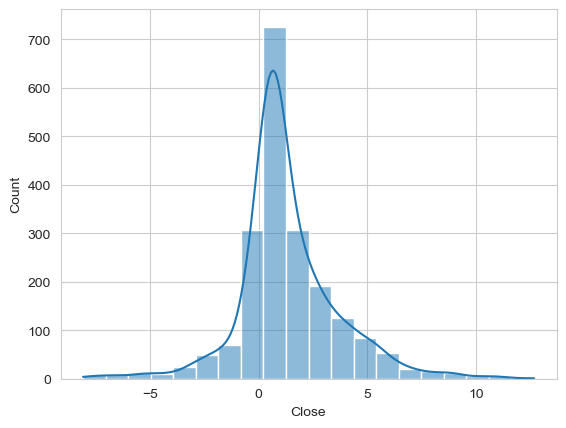

In [5]:
import seaborn as sns
sns.histplot(fracDiff(apple, 0.6).Close, kde = True, bins = 20)

<Axes: >

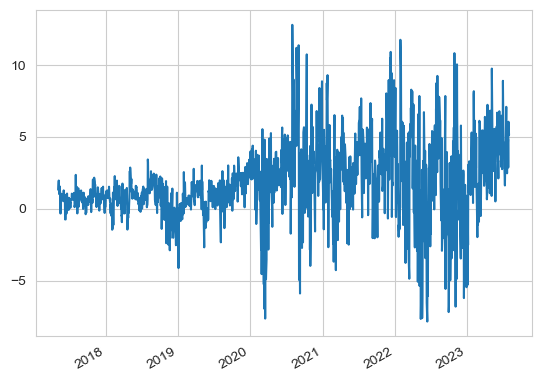

In [6]:
fracDiff_FFD(apple, 0.6).Close.plot()

<Axes: xlabel='Close', ylabel='Count'>

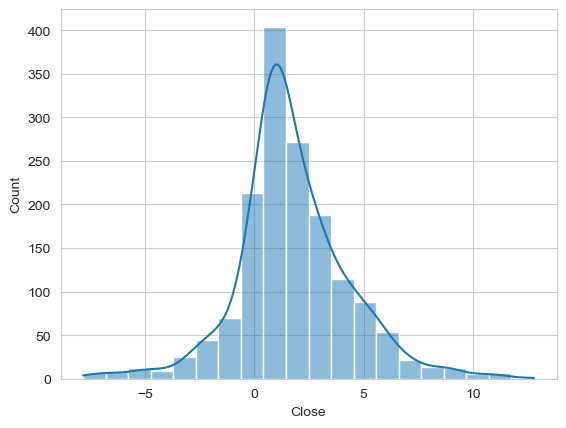

In [7]:
sns.histplot(fracDiff_FFD(apple, 0.6).Close, kde = True, bins = 20)